In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# Single-frequency 1D

## Effect of PDE and domain sampling method

In this experiment I want to understand the PDE dynamics on a simple 1D problem. I have observed a strange Gibbs-like phenomenon emerge when training using the Helmholtz equation and I have a few hypotheses. One is that this is due to violation of the homogeneity assumption when we do pseudorandom sampling of the PDE domain. If we instead train only wrt the data points, this should reduce the assumption violation. Another possibility is that it is a result of the spectral bias of the model, as it relates to the activation functions. So for this I test using different activation functions and different multipliers on the first sine activation function.

In [55]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=bio170034p
#SBATCH --partition=BatComputer
#SBATCH --gres=gpu:rtx5000:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
source activate MRE-PINN

python ../../../train.py \\
    --data_root ../../../data/BIOQIC \\
    --data_name fem_box \\
    --frequency {frequency} \\
    --xyz_slice {xyz_slice} \\
    --pde_name {pde_name} \\
    --omega0 {omega0} \\
    --n_layers {n_layers} \\
    --n_hidden {n_hidden} \\
    --activ_fn {activ_fn} \\
    --learning_rate {learning_rate} \\
    --pde_loss_wt {pde_loss_wt} \\
    --data_loss_wt {data_loss_wt} \\
    --batch_size {batch_size} \\
    --n_domain {n_domain} \\
    --n_iters {n_iters} \\
    --test_every {test_every} \\
    --save_every {save_every} \\
    --save_prefix {job_name}    
'''
name = 'train_{frequency}_{xyz_slice}_{pde_name}_{omega0}_{activ_fn}_{pde_distrib}'

# define the parameter space

param_space = ps.ParamSpace(
    frequency=[80],
    xyz_slice=['1D'],
    pde_name=['helmholtz', 'hetero'],
    omega0=[4, 8, 16],
    n_layers=5,
    n_hidden=16,
    activ_fn=['s', 't'],
    learning_rate=1e-3,
    pde_loss_wt=1,
    data_loss_wt=1e-8,
    batch_size=80,
    n_domain=128-80,
    pde_distrib=['pseudo', 'sobol', 'uniform'],
    n_iters=25000,
    test_every=1000,
    save_every=1000
)

len(param_space)

36

In [56]:
%autoreload
expt_name = '2022-07-24'

#jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

jobs = pd.read_csv(f'{expt_name}.jobs')

100%|██████████| 36/36 [00:03<00:00, 11.65it/s]
[9951620, 9951621, 9951622, 9951623, 9951624, 9951625, 9951626, 9951627, 9951628, 9951629, 9951630, 9951631, 9951632, 9951633, 9951634, 9951635, 9951636, 9951637, 9951638, 9951639, 9951640, 9951641, 9951642, 9951643, 9951644, 9951645, 9951646, 9951647, 9951648, 9951649, 9951650, 9951651, 9951652, 9951653, 9951654, 9951655]


In [62]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
ps.status(jobs)[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
9951620,train_80_1D_helmholtz_4_s_pseudo,NaN,NaN,NaN,None,None
9951621,train_80_1D_helmholtz_4_s_sobol,NaN,NaN,NaN,None,None
9951622,train_80_1D_helmholtz_4_s_uniform,NaN,NaN,NaN,None,None
9951623,train_80_1D_helmholtz_4_t_pseudo,NaN,NaN,NaN,None,None
9951624,train_80_1D_helmholtz_4_t_sobol,NaN,NaN,NaN,None,None
9951625,train_80_1D_helmholtz_4_t_uniform,NaN,NaN,NaN,None,None
9951626,train_80_1D_helmholtz_8_s_pseudo,NaN,NaN,NaN,None,None
9951627,train_80_1D_helmholtz_8_s_sobol,NaN,NaN,NaN,None,None
9951628,train_80_1D_helmholtz_8_s_uniform,NaN,NaN,NaN,None,None


In [117]:
metrics = ps.metrics(jobs)

# did all models train to 25k iterations?
assert (metrics.groupby('job_name')['iteration'].max() == 25e3).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 25e3]

param_cols = ['pde_name', 'omega0', 'activ_fn', 'pde_distrib'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['mean_squared_abs_value', 'power_density', 'mean_abs_value'] # metric values

metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean().unstack(level=[4])

def metric_map(t):
    metric_name, var_name = t
    metric_name = {
        'mean_squared_abs_value': 'MSAV',
        'mean_abs_value': 'MAV',
        'power_density': 'SPD'
    }[metric_name]
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('f_sum_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
metrics

u_pred_MSAV  \
pde_name  omega0 activ_fn pde_distrib spatial_frequency_bin spatial_region                 
helmholtz 4      s        pseudo      all                   all             4.076080e-11   
                                                            0                        NaN   
                                                            1                        NaN   
                                      1.0                   all                      NaN   
                                      2.0                   all                      NaN   
...                                                                                  ...   
hetero    16     t        uniform     6.0                   all                      NaN   
                                      7.0                   all                      NaN   
                                      8.0                   all                      NaN   
                                      9.0                   all                      NaN   
                                      10.0                  all                      NaN   

                                                                             u_pred_MSAE  \
pde_name  omega0 activ_fn pde_distrib spatial_frequency_bin spatial_region                 
helmholtz 4      s        pseudo      all                   all             1.104154e-13   
                                                            0                        NaN   
                                                            1                        NaN   
                                      1.0                   all                      NaN   
                                      2.0                   all                      NaN   
...                                                                                  ...   
hetero    16     t        uniform     6.0                   all                      NaN   
                                      7.0                   all                      NaN   
                                      8.0                   all                      NaN   
                                      9.0                   all                      NaN   
                                      10.0                  all                      NaN   

                                                                             u_true_MSAV  \
pde_name  omega0 activ_fn pde_distrib spatial_frequency_bin spatial_region                 
helmholtz 4      s        pseudo      all                   all             4.030679e-11   
                                                            0                        NaN   
                                                            1                        NaN   
                                      1.0                   all                      NaN   
                                      2.0                   all                      NaN   
...                                                                                  ...   
hetero    16     t        uniform     6.0                   all                      NaN   
                                      7.0                   all                      NaN   
                                      8.0                   all                      NaN   
                                      9.0                   all                      NaN   
                                      10.0                  all                      NaN   

                                                                            lu_pred_MSAV  \
pde_name  omega0 activ_fn pde_distrib spatial_frequency_bin spatial_region                 
helmholtz 4      s        pseudo      all                   all                 0.109343   
                                                            0                        NaN   
                                                            1                        NaN   
                          

<IPython.core.display.Javascript object>


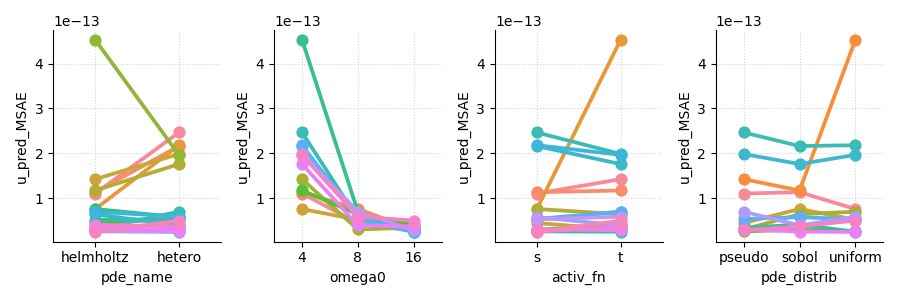

In [139]:
fig = ps.plot(
    metrics.reset_index(),
    x=param_cols,
    y=['u_pred_MSAE'],
    height=3,
    width=2.25,
    legend=False,
    tight=True
)

Pretty much all models fit the wave field to a very low error.

<IPython.core.display.Javascript object>


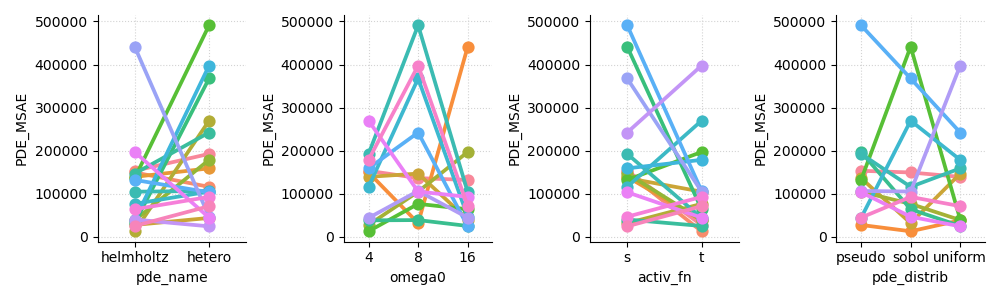

In [141]:
fig = ps.plot(
    metrics.reset_index(),
    x=param_cols,
    y=['PDE_MSAE'],
    height=3,
    width=2.5,
    legend=False,
    tight=True
)

There is much more variance in minimizing the PDE residual, and no clear trends jump out at first.

<IPython.core.display.Javascript object>


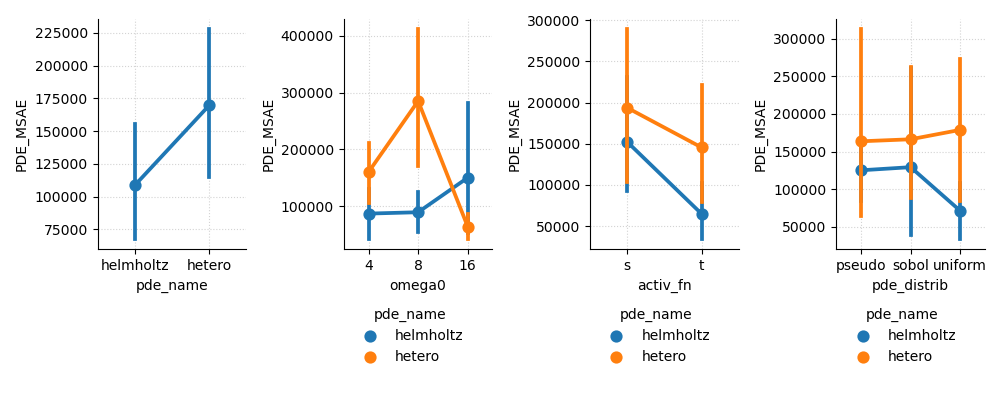

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [142]:
fig = ps.plot(
    metrics.reset_index(),
    x=param_cols,
    y=['PDE_MSAE'],
    hue='pde_name',
    height=4, width=2.5,
    tight=True
)

Overall it seems that the Helmholtz PDE residual was easier to minimize than the heterogeneous PDE. A trend with the activation functions seems to emerge here, as well. The tanh activation function may make it easier to minimize the PDE residual than sin activation.

<IPython.core.display.Javascript object>


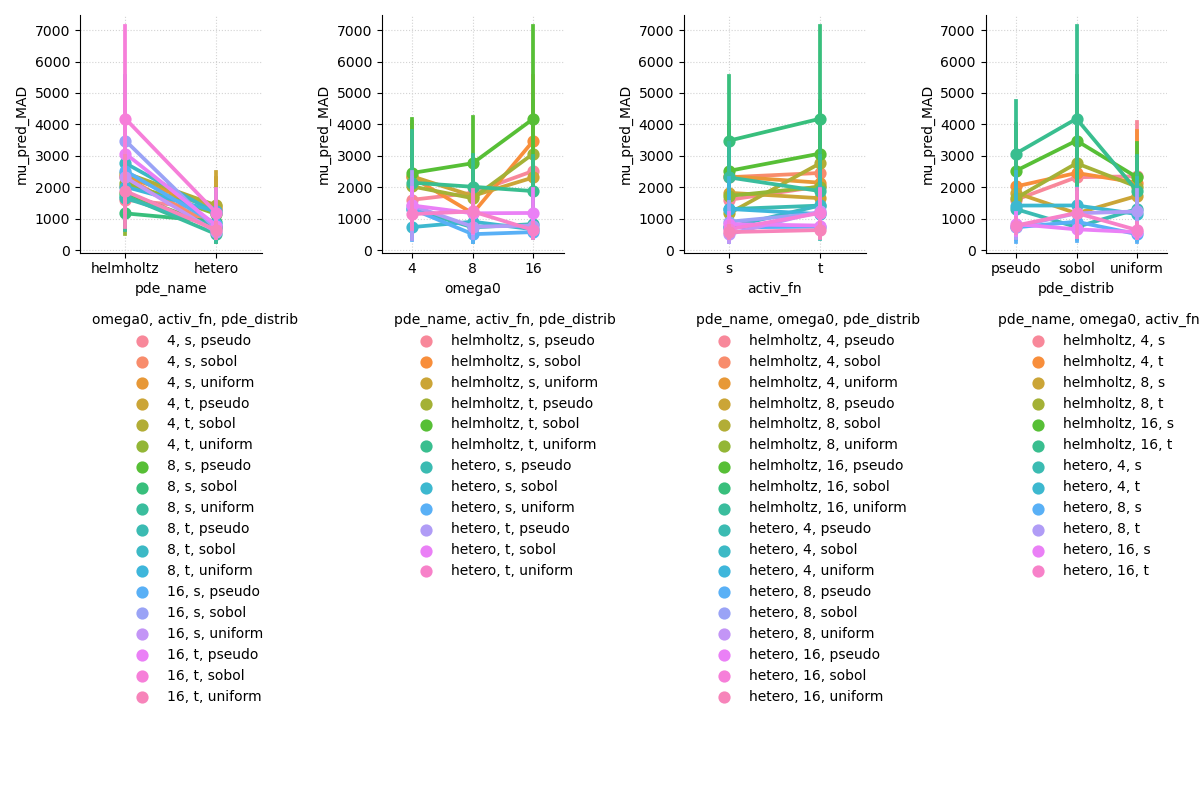

In [121]:
fig = ps.plot(
    metrics.reset_index(),
    x=param_cols,
    y=['mu_pred_MAD'],
    height=8, width=3,
    tight=True
)

Here we are looking at the median absolute deviation of the predict stiffness in each of the regions. There is a very clear signal in the PDE name plot: Using the heterogeneous PDE results in mucn lower error in the predicted stiffness per region, compared to the Helmholtz PDE. There may be a trend in the omeg0 and activ_fn plots as well, but it's less clear.

<IPython.core.display.Javascript object>


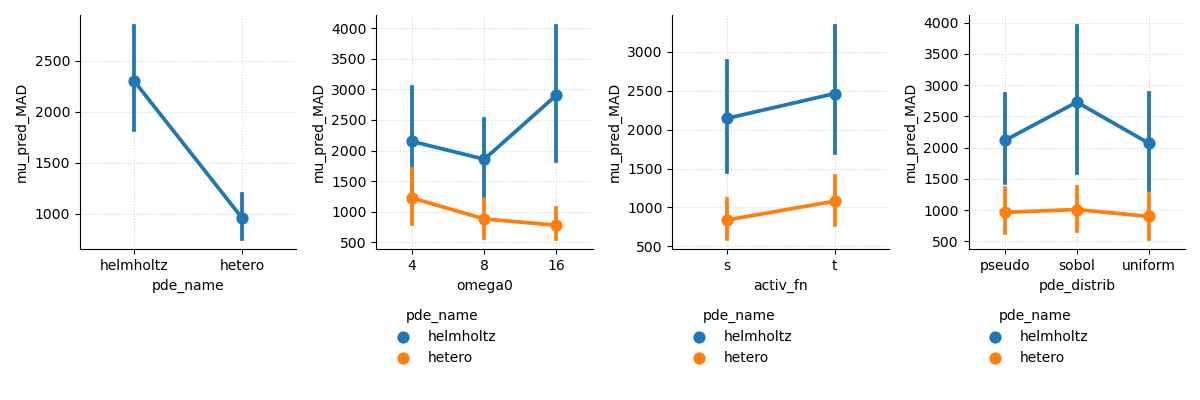

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [129]:
fig = ps.plot(
    metrics.reset_index(),
    x=param_cols,
    y=['mu_pred_MAD'],
    hue='pde_name',
    height=4, width=3,
    tight=True
)

This plot emphasizes a clear and statistically significant signal from using the heterogeneous PDE instead of the Helmholtz PDE, resulting in more accurate predicted stiffness. It also appears that, particularly for the hetero PDE, higher omega0 is better and using sin instead of tanh activations might be better.

In [166]:
agg = metrics.reset_index().groupby(param_cols).mean()

<IPython.core.display.Javascript object>


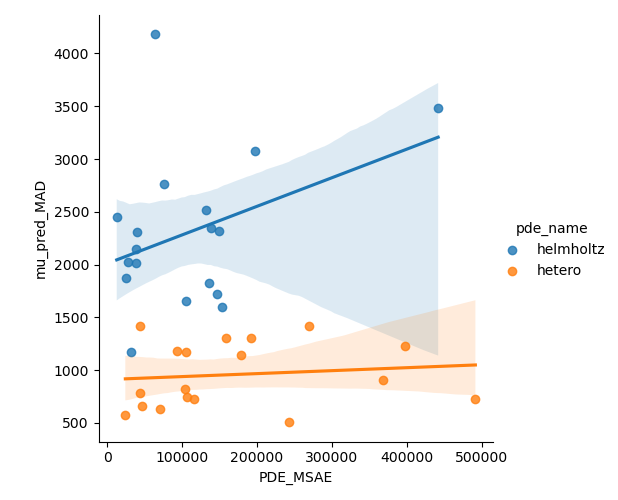

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(data=agg.reset_index(), x='PDE_MSAE', y='mu_pred_MAD', hue='pde_name')

Even though using the heterogeneous PDE instead of Helmholtz consistently improves reconstruction quality, there is not a clear correlation between the PDE residual and the reconstruction quality. If anything, the Helmholtz residual is more strongly correlated with mu error, even though mu error is higher in absolute terms.

<IPython.core.display.Javascript object>


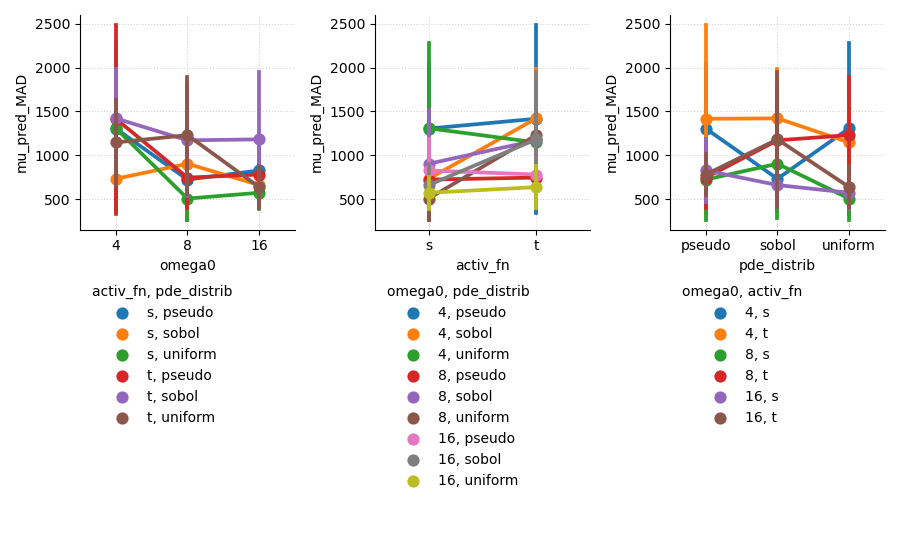

In [175]:
m = metrics.reset_index()

fig = ps.plot(
    m[m.pde_name == 'hetero'].copy(),
    x=param_cols[1:],
    y=['mu_pred_MAD'],
    height=5.5, width=3,
    tight=True
)

There does not seem to be a relationship with the PDE distribution. So even though I was correct that the Helmholtz PDE seems worse then heterogeneous, the reason why does not seem to be related to the domain sampling distribution.